In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hide content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)
  

import re



# Text Analysis

The examples that we have seen so far in this chapter have cleaned text fields and converted strings into quantitative features for analysis. In this section, we demonstrate how to analyze documents. This analysis, called text mining, transforms unstructured text into a quantitative representation with the aim of uncovering meaningful patterns and insights.

We do not provide a comprehensive treatment of text mining here, but introduce a few key ideas through an example. We analyze the State of the Union speeches from 1790 to 2022. The State of the Union is a report given by the US president to the US Congress annually. It contains information on the situation in the country and recommendations for Congress to consider. The American Presidency Project[^APP] has the text from all of these speeches.

[^APP]: https://www.presidency.ucsb.edu/

We have collected these speeches into one file which we open and read as strings.

In [2]:
with open("/Users/nolan/DS-100/fa17-course-dev/lec/reg-ex/data/stateoftheunion1790-2022.txt", "r") as f:
    text = f.read()

We saw earlier in the chapter that the speeches are delimited by lines of the form \*\*\*. We can use a regular expression to count the number of occurrences of three asterisks.

In [3]:
print("Count ***s", len(re.findall(r"\*\*\*", text)))

Count ***s 232


The file contains 232 speeches (or 232 documents), and we can use string manipulation to create separate "documents" for each.

In [4]:
records = text.split("***")

Before we can apply text mining techniques, we must clean and prepare each document. For example, following the three asterisks there is a blank line and then three lines of information about the speech. We want to remove these from the document and place this information in corresponding features. 

In [5]:
def extract_parts(line):
    parts = line.split("\n")
    name = parts[3].strip()
    date = parts[4].strip()
    text = "\n".join(parts[5:]).strip()
    return [name, date, text]

df = pd.DataFrame([extract_parts(l) for l in records[1:]],
                   columns = ["Name", "Date", "Text"])
    
df.head()

,Name,Date,Text
0,George Washington,"January 8, 1790",Fellow-Citizens of the Senate and House of Rep...
1,George Washington,"December 8, 1790",Fellow-Citizens of the Senate and House of Rep...
2,George Washington,"October 25, 1791",Fellow-Citizens of the Senate and House of Rep...
3,George Washington,"November 6, 1792",Fellow-Citizens of the Senate and House of Rep...
4,George Washington,"December 3, 1793",Fellow-Citizens of the Senate and House of Rep...


To clean the documents, we remove blank lines, extra whitespace, convert uppercase letters to lowercase, and eliminate all literals that are not letters and spaces.  Additionally, we remove remarks between squuare brackets, such as \[laughter\], because these are clarifications or comments from the audience, and we remove the phrase "The President." when it appears at the beginning of a line because it refers to the president speaking and is not part of the speech itself. Notice in the regular expressions below how we: escape the metacharacter meaning of left and right brackets with a backslash in order to locate the bracketed remarks that are not part of the speech; use the caret inside the two equivalence classes, one time to locate any literal except the right bracket and another time to match everything that isn't a letter or whitespace (the shortcut for whitespace is `\s`); and locate the term "The President." at the beginning of a new line. Also consider the sequence in which these string replacemnts are carried out. We want to be sure to replace "The President" first, before we start replacing end of line characters with blanks.   

In [6]:
df['clean text'] = (
    df['Text']
    .str.replace("\n\s*The President\.", "")
    .str.replace("\[[^\]]+\]","")
    .str.replace("\n", " ")
    .str.lower()
    .str.replace(r"[^a-z\s]", " ")
)

<ipython-input-6-326613f2bdaa>:2: FutureWarning:

The default value of regex will change from True to False in a future version.



In [7]:
df['clean text'].head()

0    fellow citizens of the senate and house of rep...
1    fellow citizens of the senate and house of rep...
2    fellow citizens of the senate and house of rep...
3    fellow citizens of the senate and house of rep...
4    fellow citizens of the senate and house of rep...
Name: clean text, dtype: object

Now we're ready to perform a little text mining. The key idea idea is to analyze the speeches as collections of words. To do this, we organize the words in each document into a *word vector*. We break each document up into separate strings of one word each, which are referred to as *terms* or *tokens*. This process, called *tokenization*, often includes *stemming*, where a word is reduced to its "stem." For example, "runs", "running", and "ran" are all mapped to the same stem, "run". Stemming reduces similar words to the same core to make it easier to find similarities between documents. Another processing step removes *stop words*, such as "is", "and", "the", and  "a", from the document. The rational being that these word are so common that they are not helpful in comparing documents.  

Below we use a stemming method in the NLTK library to tokenize (by splitting on whitepace) and stem the words in a string. We will use this tokenizer on the speeches.

In [8]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming_tokenizer(str_input):
    words = re.split(" ", str_input)
    words = [porter_stemmer.stem(word) for word in words]
    return words

To create a speech's word vector, we tally up the number of time each word in a dictionary occurs in the speech. The dictionary used to create the word vectors might simply be the collection of all unique words across all of the documents being analyzed, which is referred to as a *bag of words*. 

Representing a speech in this way ignores the actual order of the words. It may not be immediately obvious that this representation can be useful. The bi-gram is an extension of this notion, where pairs of words are the tokens. You can imagine that this extension can bring more nuance to a text analysis. 

The count of a word in a document is called the *term frequency*. Ideally the vectors of term frequencies can be used to compare documents. To make these comparisons, we typically normalize a term frequency by its *inverse document frequency*, which is a count of the number of documents the word appears in. A word that appears in all of the documents will likely not be of much use in our comparisons. The product of the term frequency and inverse document frequency is called the tf-idf.  

We use the `TfidfVectorizer` method in scikit learn to compute the tf-id vectors, and provide our tokenizer to stem the words.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(tokenizer=stemming_tokenizer, stop_words='english')
tfidf = vec.fit_transform(df['clean text'])


/Users/nolan/anaconda3/envs/textbook/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not

In [10]:
tfidf.shape

(232, 13130)

Each of the 232 speeches is represented by a 13348 vector of tf-idf values. 

Now that we have converted documents into high-dimensional vectors, we can use dimension reduction techniques to look for patterns.We close this section with a plot of the tf-idf vectors of the 232 documents. These have been reduced to two-dimensional representations in the scatter plot below. Each point there is on of the speeches, and these are color-coded by year. We note that speeches in the same era are close to each other, even when given by presidents of different political parties. Also notable are a couple of anomalous speeches. Something to look into. 

In [11]:
np.random.seed(42)
import scipy as sp
(u, s, vt) = sp.sparse.linalg.svds(tfidf, k=2)

In [12]:
df['Year'] = df['Date'].str[-4:].astype('int')
df['x'] = u[:,0]
df['y'] = u[:,1]


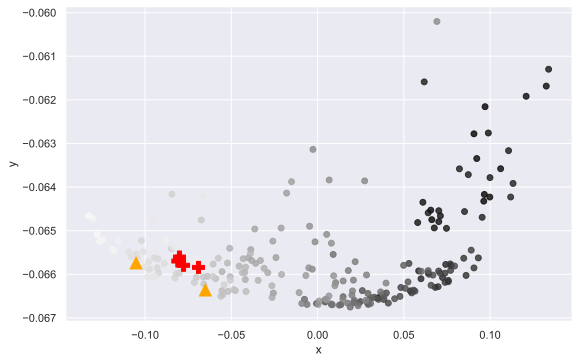

In [30]:
sns.lmplot(x = 'x', y = 'y', data = df, hue='Year', legend=False, 
           fit_reg=False, palette="gray", aspect=1.6)
(u0,v0) = df[df['Name'] == "Joseph R. Biden, Jr."][['x', 'y']].values[0]
(u1,v1) = df[df['Name'] == "Joseph R. Biden, Jr."][['x', 'y']].values[1]
(x0,y0) = df[df['Name'] == "Donald J. Trump"][['x', 'y']].values[0]
(x1,y1) = df[df['Name'] == "Donald J. Trump"][['x', 'y']].values[1]
(x2,y2) = df[df['Name'] == "Donald J. Trump"][['x', 'y']].values[2]
(x3,y3) = df[df['Name'] == "Donald J. Trump"][['x', 'y']].values[3]
(w0,z0) = df[df['Name'] == "George W. Bush"][['x', 'y']].values[0]
(w1,z1) = df[df['Name'] == "George W. Bush"][['x', 'y']].values[1]
(w2,z2) = df[df['Name'] == "George W. Bush"][['x', 'y']].values[2]
(w3,z3) = df[df['Name'] == "George W. Bush"][['x', 'y']].values[3]
plt.plot(u0,v0,'^', markersize=12, color="orange")
plt.plot(u1,v1,'^', markersize=12, color="orange")
plt.plot(x0,y0,'P', markersize=12, color="red")
plt.plot(x1,y1,'P', markersize=12, color="red")
plt.plot(x2,y2,'P', markersize=12, color="red")
plt.plot(x3,y3,'P', markersize=12, color="red")
#plt.plot(w0,z0,'P', markersize=12, color="green")
#plt.plot(w1,z1,'P', markersize=12, color="green")
#plt.plot(w2,z2,'P', markersize=12, color="green")
#plt.plot(w3,z3,'P', markersize=12, color="green")
#plt.savefig("SOTUspeeches.pdf")


In [14]:
from scipy.spatial import distance

#distance.jensenshannon(tfidf[0, :],tfidf[1, :])

In [15]:
X = tfidf.toarray()

In [16]:
X.shape

(232, 13130)

In [17]:
X[:, 1]

array([0., 0., 0., ..., 0., 0., 0.])

In [18]:
distance.jensenshannon(X[0, :],X[1, :])

0.6015909036121101

In [19]:
distance.jensenshannon(X[0, :],X[0, :])

0.0

In [20]:
#from sklearn.manifold import MDS

#embedding = MDS(n_components=2)
#X_transformed = embedding.fit_transform(tfidf)
#X_transformed.shape

0      0.10
1      0.09
2      0.10
       ... 
229   -0.08
230   -0.11
231   -0.07
Name: x, Length: 232, dtype: float64